# Can DINO detect object instances?

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
import torch
import torch.nn.functional as F
import tqdm
from einops import parse_shape, rearrange, reduce
from matplotlib.patches import Circle
from matplotlib.ticker import PercentFormatter
from osc.data.clevr_with_masks import get_iterator
from osc.data.utils import normalize_tf, unnormalize_pt
from osc.utils import cos_pairwise
from skimage.filters import threshold_otsu
from timm.models.vision_transformer import vit_base_patch8_224_dino

# Silence TF logs
tf.ones(4)

B = 128
device = "cuda:1"

2022-05-01 18:11:59.031764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setup

Pretrained DINO model

In [2]:
m = vit_base_patch8_224_dino(pretrained=True).eval().to(device)
m.default_cfg

{'url': 'https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth',
 'num_classes': 0,
 'input_size': (3, 224, 224),
 'pool_size': None,
 'crop_pct': 0.9,
 'interpolation': 'bicubic',
 'fixed_input_size': True,
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'patch_embed.proj',
 'classifier': 'head',
 'architecture': 'vit_base_patch8_224_dino'}

Input images

imgs_pt torch.Size([128, 3, 224, 224]) torch.float32
obj_coords torch.Size([128, 11, 2]) torch.float32
visibility torch.Size([128, 11]) torch.bool
imgs_np (128, 224, 224, 3) float32


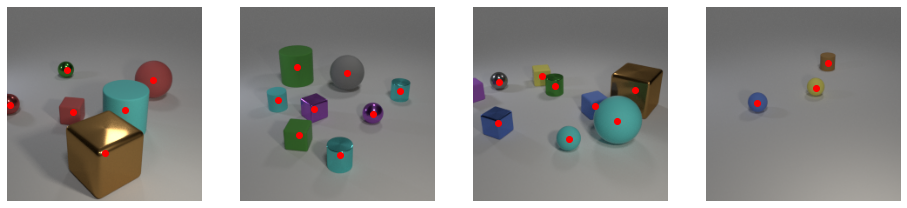

In [3]:
def center_crop(sample_dict):
    img = sample_dict["image"][8:-8:, 48:-48]
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = normalize_tf(img, m.default_cfg["mean"], m.default_cfg["std"])
    img = tf.transpose(img, [2, 0, 1])
    # [11, (h w)]
    obj_coords = tf.stack(
        (
            sample_dict["pixel_coords"][:, 1] - 8.0,
            sample_dict["pixel_coords"][:, 0] - 48.0,
        ),
        axis=-1,
    )
    visibility = tf.reduce_all(
        (
            sample_dict["visibility"],
            tf.reduce_all(obj_coords >= 0, axis=-1),
            tf.reduce_all(obj_coords < 224, axis=-1),
        ),
        axis=0,
    )
    return img, obj_coords, visibility


imgs_pt, obj_coords, visibility = (
    get_iterator("~/multi-object-datasets/", numpy=False)
    .map(center_crop)
    .batch(B)
    .take(1)
    .get_single_element()
)
imgs_pt = torch.from_numpy(imgs_pt.numpy())
obj_coords = torch.from_numpy(obj_coords.numpy())
visibility = torch.from_numpy(visibility.numpy())
print("imgs_pt", imgs_pt.shape, imgs_pt.dtype)
print("obj_coords", obj_coords.shape, obj_coords.dtype)
print("visibility", visibility.shape, visibility.dtype)

imgs_np = unnormalize_pt(imgs_pt, m.default_cfg["mean"], m.default_cfg["std"])
imgs_np = rearrange(imgs_np.numpy(), "B C H W -> B H W C")
print("imgs_np", imgs_np.shape, imgs_np.dtype)

fig, axs = plt.subplots(
    1, 4, figsize=(16, 4), sharex=True, sharey=True, facecolor="white"
)
for b in range(4):
    axs[b].imshow(imgs_np[b])
    axs[b].scatter(
        obj_coords[b, visibility[b], 1],
        obj_coords[b, visibility[b], 0],
        color="red",
    )
    axs[b].set_axis_off()
display(fig)
plt.close(fig)

Feature extraction

In [4]:
with torch.no_grad():
    f_patches = m.forward_features(imgs_pt.to(device))
f_global = f_patches[:, 0, :]
f_patches = rearrange(
    f_patches[:, 1:, :],
    "B (H W) C -> B H W C",
    H=m.patch_embed.grid_size[0],
    W=m.patch_embed.grid_size[1],
)
B, H, W, C = f_patches.shape
print("f_patches", f_patches.shape, f_patches.dtype)

f_patches torch.Size([128, 28, 28, 768]) torch.float32


## Single image, manual coordinates

Given the self cosine similarity of every patch `(H, W)` with every patch `(h, w)` and knowing the coords of the objects, visualize some similarity maps.

Things to try:
- centering, i.e. for each key coordinate `(h, w)`, compute the avg similarity of all `(H, W)` queries and subtract it.
- sharpness of softmax, i.e. temperature

Things to measure:
- entropy of the heatmap \
  $\text{Ent}(H, W) = \sum_{h,w} -\alpha_{H,W,h,w} \log(\alpha_{H,W,h,w})$

- center of mass of the heatmap and its radius \
  $\mu(H, W) = \sum_{h,w} (h, w) \cdot \alpha_{H,W,h,w}$ \
  $\sigma(H, W) = \sum_{h,w} || (h, w) - \mu(H, W) ||^2  \cdot \alpha_{H,W,h,w}$

- Per-slot Otsu thresholding of attention and percentage of the area that would result as foreground

### Per-object viz at various temperatures and centering

In [5]:
def mu_sigma(attn):
    H, W, h, w = attn.shape
    # [h w 2]
    grid = torch.meshgrid(
        torch.arange(h, device=attn.device),
        torch.arange(w, device=attn.device),
        indexing="ij",
    )
    grid = torch.stack(grid, dim=-1)

    # [H, W, h, w, _] * [_, _, h, w, 2] -> [H W 2]
    mus = reduce(
        attn[:, :, :, :, None] * grid[None, None, :, :, :],
        "H W h w two -> H W two",
        reduction="sum",
    )

    # [H, W, h, w] * || [_, _, h, w, 2] - [H, W, _, _, 2] ||^2 -> [H W]
    sigmas = reduce(
        attn[:, :, :, :]
        * (grid[None, None, :, :, :] - mus[:, :, None, None, :]).pow(2).sum(dim=-1),
        "H W h w -> H W",
        reduction="sum",
    )
    return mus, sigmas


def entropy(attn):
    H, W, h, w = attn.shape
    return reduce(-attn * attn.log(), "H W h w -> H W", reduction="sum")


def otsu_threshold(attn):
    H, W, h, w = attn.shape
    thresholds = np.empty((H, W))
    attn_np = attn.cpu().numpy()
    for idx_HW in np.ndindex(H, W):
        thresholds[idx_HW] = threshold_otsu(attn_np[idx_HW])
    thresholds = torch.from_numpy(thresholds).to(attn.device)
    fg_percents = attn > thresholds[:, :, None, None]
    fg_percents = torch.count_nonzero(fg_percents, dim=(-2, -1)) / (h * w)
    return thresholds, fg_percents

Centering False
Temperature 0.01


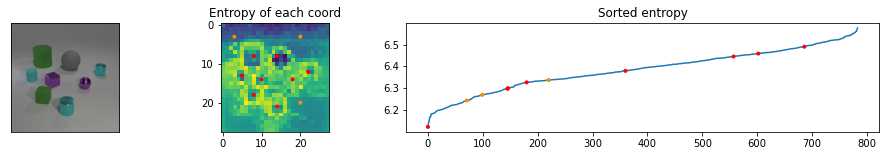

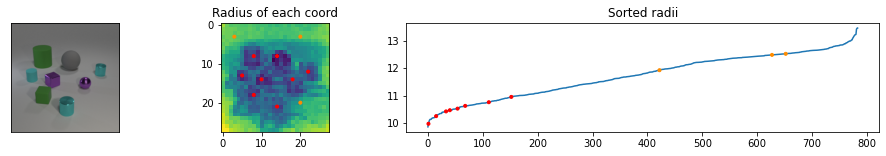

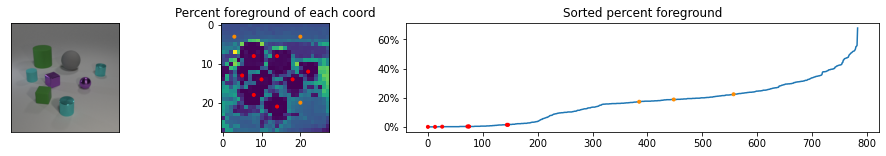

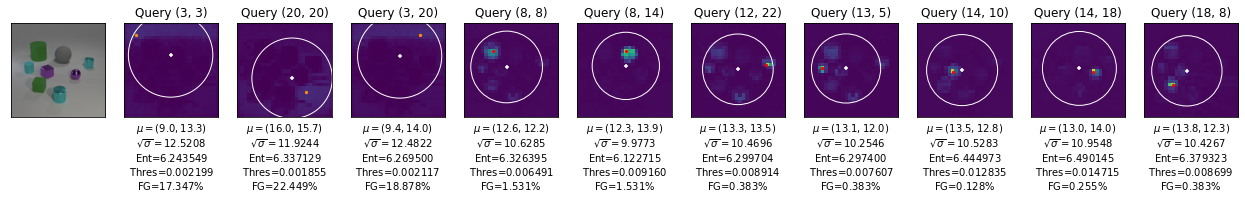

Centering False
Temperature 1


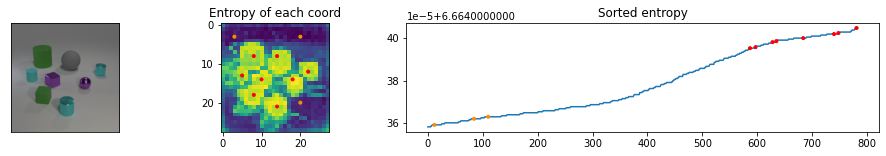

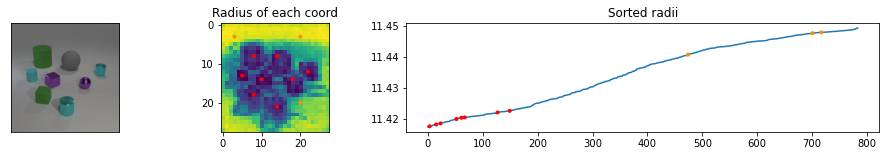

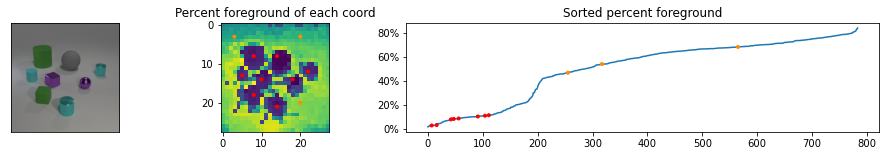

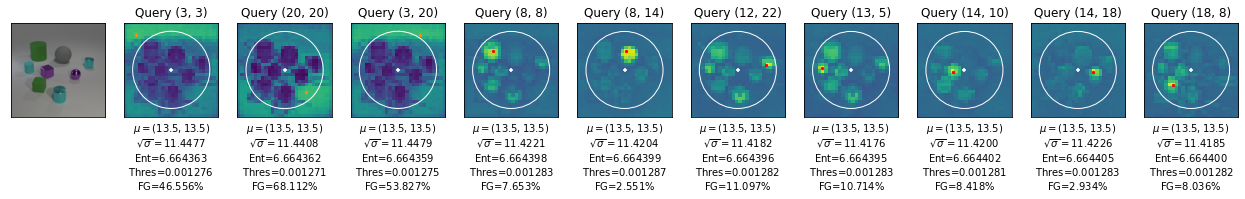

Centering False
Temperature 3


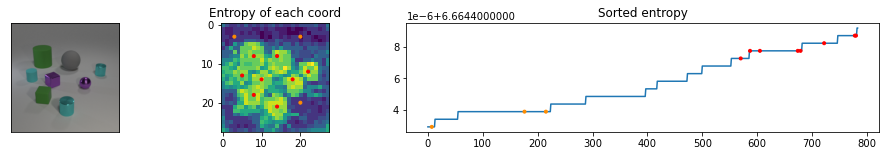

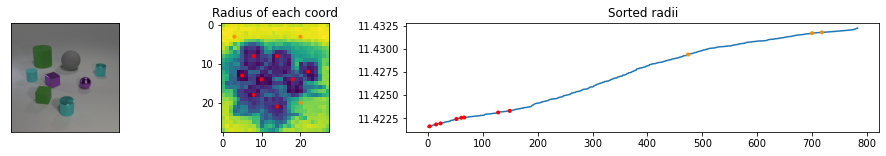

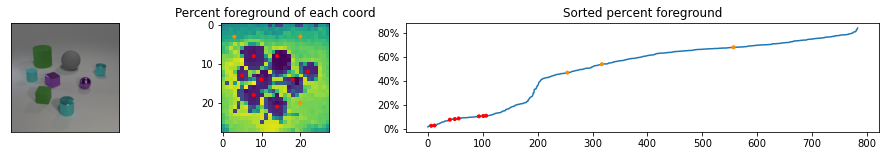

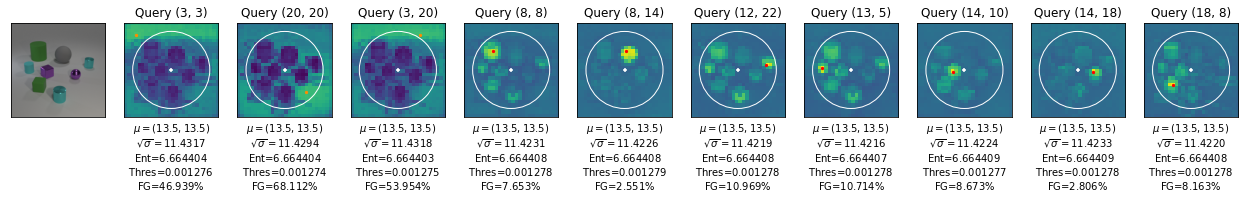

Centering True
Temperature 0.01


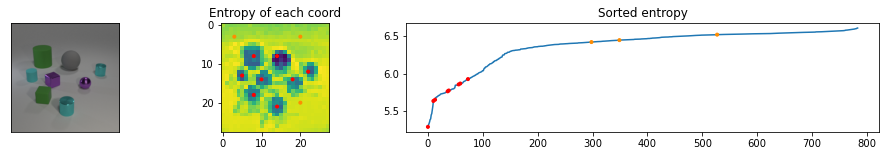

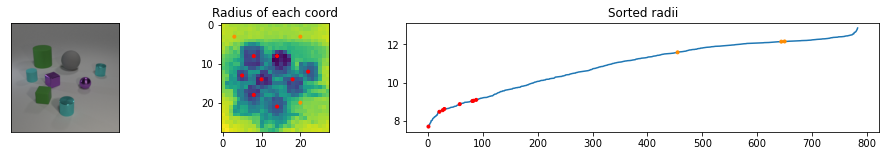

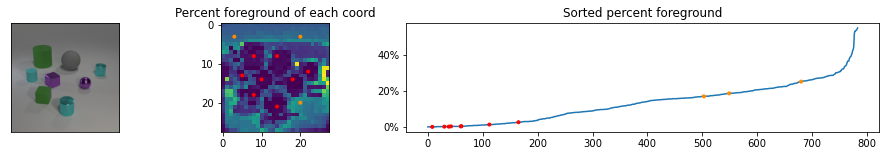

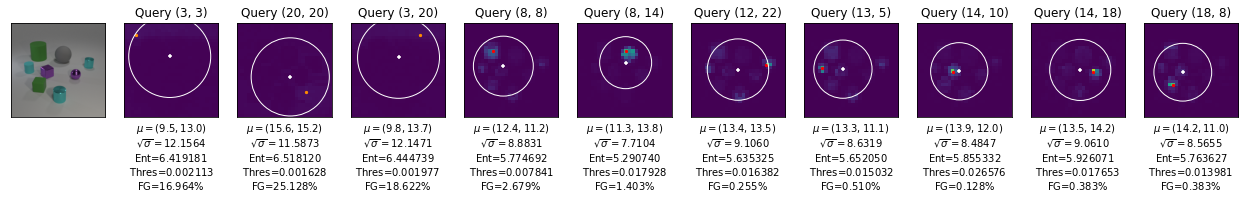

Centering True
Temperature 1


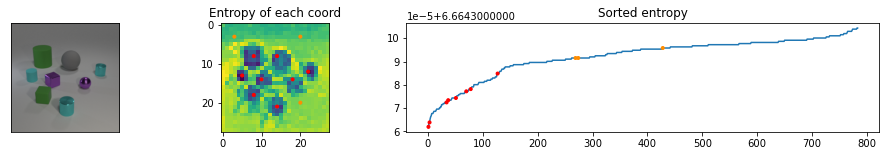

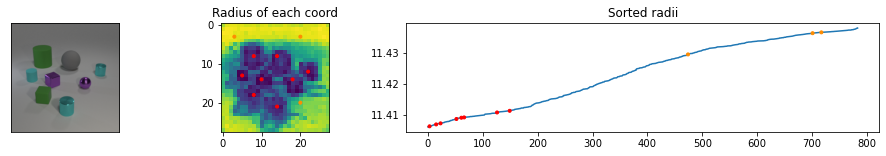

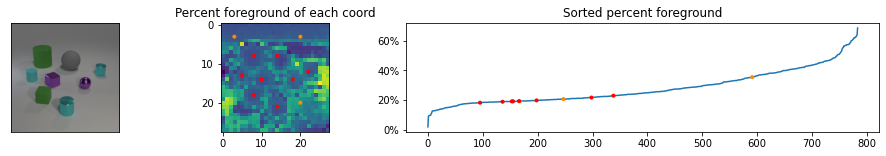

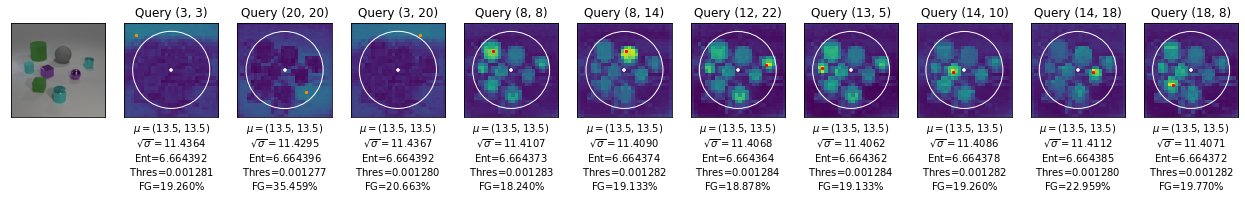

Centering True
Temperature 3


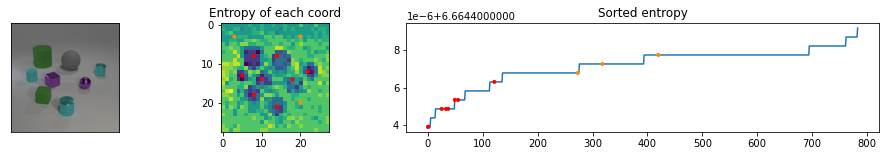

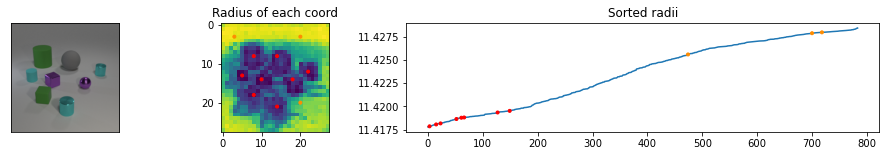

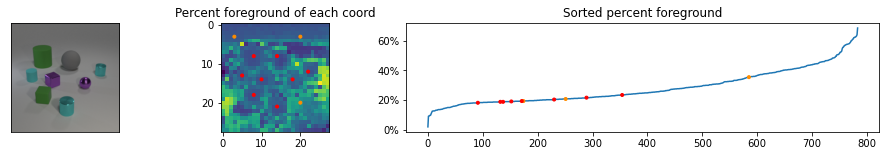

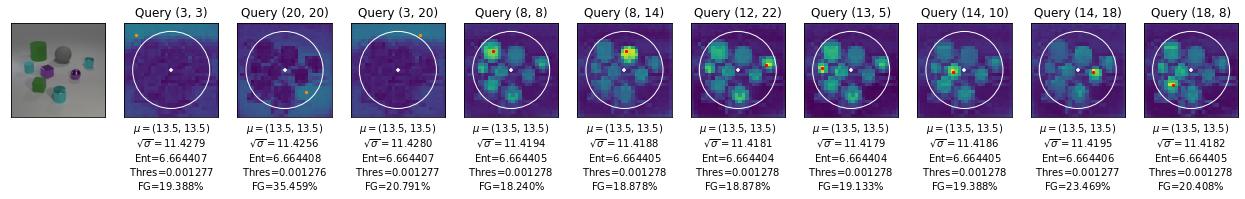

In [6]:
b = 1
coords = [
    # Background
    (3, 3),
    (20, 20),
    (3, 20),
    # Objects
    (8, 8),
    (8, 14),
    (12, 22),
    (13, 5),
    (14, 10),
    (14, 18),
    (18, 8),
    (21, 14),
]
colors = ["darkorange"] * 3 + ["red"] * 8
coords_flat = np.ravel_multi_index(np.array(coords).T, (H, W))
cos = cos_pairwise(f_patches[b])

for centering in [False, True]:
    for temperature in [0.01, 1, 3]:
        print("Centering", centering)
        print("Temperature", temperature)

        attn = rearrange(cos, "H W h w -> H W (h w)")
        if centering:
            attn = attn - reduce(attn, "H W hw -> () () hw", reduction="mean")
        attn = attn.div(temperature * np.sqrt(C)).softmax(-1)
        attn = rearrange(attn, "H W (h w) -> H W h w", H=H, h=H)
        mus, sigmas = mu_sigma(attn)
        ent = entropy(attn)
        thresholds, fg_percents = otsu_threshold(attn)

        attn = attn.cpu()
        mus = mus.cpu()
        sigmas = sigmas.cpu()
        ent = ent.cpu()
        thresholds = thresholds.cpu()
        fg_percents = fg_percents.cpu()

        # Entropy
        fig, axs = plt.subplots(
            1,
            3,
            figsize=2.0 * np.array([8, 1]),
            facecolor="white",
            gridspec_kw={"width_ratios": [1, 1, 3]},
        )
        ax = axs[0]
        ax.imshow(imgs_np[b])
        ax.set_xticks([])
        ax.set_yticks([])
        ax = axs[1]
        ax.imshow(ent)
        ax.scatter(
            [w for h, w in coords], [h for h, w in coords], color=colors, marker="."
        )
        ax.set_title("Entropy of each coord")
        ax = axs[2]
        ent_sorted, idx_sorted = torch.sort(rearrange(ent, "H W -> (H W)"))
        ax.plot(np.arange(H * W), ent_sorted)
        ax.scatter(
            torch.argsort(idx_sorted)[coords_flat],
            ent.flatten()[coords_flat],
            color=colors,
            marker=".",
            zorder=10,
        )
        ax.set_title("Sorted entropy")
        display(fig)
        plt.close(fig)

        # Radius
        fig, axs = plt.subplots(
            1,
            3,
            figsize=2.0 * np.array([8, 1]),
            facecolor="white",
            gridspec_kw={"width_ratios": [1, 1, 3]},
        )
        ax = axs[0]
        ax.imshow(imgs_np[b])
        ax.set_xticks([])
        ax.set_yticks([])
        ax = axs[1]
        ax.imshow(sigmas.sqrt())
        ax.scatter(
            [w for h, w in coords], [h for h, w in coords], color=colors, marker="."
        )
        ax.set_title("Radius of each coord")
        ax = axs[2]
        radii_sorted, idx_sorted = torch.sort(rearrange(sigmas.sqrt(), "H W -> (H W)"))
        ax.plot(np.arange(H * W), radii_sorted)
        ax.scatter(
            torch.argsort(idx_sorted)[coords_flat],
            sigmas.sqrt().flatten()[coords_flat],
            color=colors,
            marker=".",
            zorder=10,
        )
        ax.set_title("Sorted radii")
        display(fig)
        plt.close(fig)

        # Otsu
        fig, axs = plt.subplots(
            1,
            3,
            figsize=2.0 * np.array([8, 1]),
            facecolor="white",
            gridspec_kw={"width_ratios": [1, 1, 3]},
        )
        ax = axs[0]
        ax.imshow(imgs_np[b])
        ax.set_xticks([])
        ax.set_yticks([])
        ax = axs[1]
        ax.imshow(fg_percents)
        ax.scatter(
            [w for h, w in coords], [h for h, w in coords], color=colors, marker="."
        )
        ax.set_title("Percent foreground of each coord")
        ax = axs[2]
        fg_percents_sorted, idx_sorted = torch.sort(
            rearrange(fg_percents, "H W -> (H W)")
        )
        ax.plot(np.arange(H * W), fg_percents_sorted)
        ax.scatter(
            torch.argsort(idx_sorted)[coords_flat],
            fg_percents.flatten()[coords_flat],
            color=colors,
            marker=".",
            zorder=10,
        )
        ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))
        ax.set_title("Sorted percent foreground")
        display(fig)
        plt.close(fig)

        fig, axs = plt.subplots(
            1, len(coords), figsize=2.0 * np.array([len(coords), 1]), facecolor="white"
        )
        axs.flat[0].imshow(imgs_np[b])
        for ax, hw, c in zip(axs.flat[1:], coords, colors):
            ax.set_title(f"Query {hw}")
            ax.set_xlabel(
                "\n".join(
                    [
                        rf"$\mu=({mus[hw][0]:.1f}, {mus[hw][1]:.1f})$",
                        rf"$\sqrt{{\sigma}}={np.sqrt(sigmas[hw]):.4f}$",
                        rf"Ent=${ent[hw]:.6f}$",
                        rf"Thres=${thresholds[hw]:.6f}$",
                        rf"FG=${100*fg_percents[hw]:.3f}\%$",
                    ]
                )
            )
            ax.imshow(attn[hw], interpolation="none", vmin=attn.min(), vmax=attn.max())
            ax.scatter(hw[1], hw[0], color=c, s=20, marker=".")
            ax.scatter(mus[hw][1], mus[hw][0], color="white", s=10, marker="+")
            ax.add_patch(
                Circle(
                    (mus[hw][1], mus[hw][0]),
                    radius=np.sqrt(sigmas[hw]),
                    fill=False,
                    color="white",
                )
            )
            ax.set_xlim([-0.5, W - 0.5])
            ax.set_ylim(
                [
                    H - 0.5,
                    -0.5,
                ]
            )

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        display(fig)
        plt.close(fig)

### Statistics at various temperatures and with or without centering.

Which one works best for separating instances?

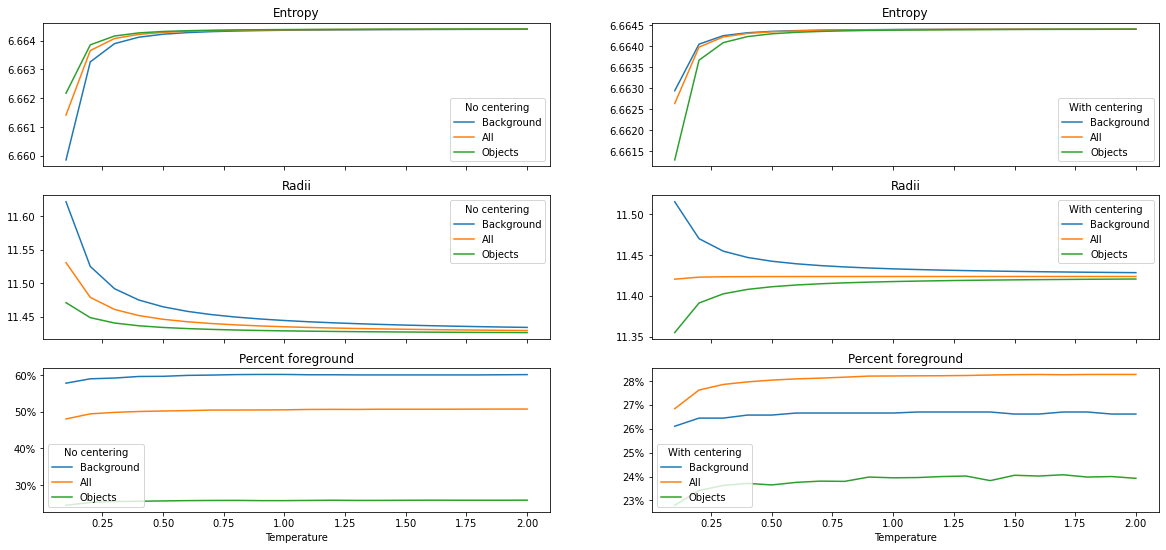

In [7]:
b = 1
coords = [
    # Background
    (3, 3),
    (20, 20),
    (23, 23),
    (2, 10),
    (3, 20),
    (24, 3),
    (25, 5),
    # Objects
    (8, 8),
    (8, 14),
    (12, 22),
    (13, 5),
    (14, 10),
    (14, 18),
    (18, 8),
    (21, 14),
]
coords_flat = np.ravel_multi_index(np.array(coords).T, (H, W))
cos = cos_pairwise(f_patches[b])

temperatures = np.linspace(0.1, 2, num=20)
fig, axs = plt.subplots(3, 2, figsize=(20, 9), facecolor="white", sharex=True)
for centering in [False, True]:
    ent_all = []
    ent_bg = []
    ent_obj = []

    rad_all = []
    rad_bg = []
    rad_obj = []

    perc_all = []
    perc_bg = []
    perc_obj = []

    for temperature in temperatures:
        attn = rearrange(cos, "H W h w -> H W (h w)")
        if centering:
            attn = attn - reduce(attn, "H W hw -> () () hw", reduction="mean")
        attn = attn.div(temperature * np.sqrt(C)).softmax(-1)
        attn = rearrange(attn, "H W (h w) -> H W h w", H=H, h=H)
        mus, sigmas = mu_sigma(attn)
        ent = entropy(attn)
        thresholds, fg_percents = otsu_threshold(attn)

        ent_all.append(ent.mean().item())
        ent_bg.append(ent.flatten()[coords_flat[:3]].mean().item())
        ent_obj.append(ent.flatten()[coords_flat[3:]].mean().item())

        radii = sigmas.sqrt()
        rad_all.append(radii.mean().item())
        rad_bg.append(radii.flatten()[coords_flat[:3]].mean().item())
        rad_obj.append(radii.flatten()[coords_flat[3:]].mean().item())

        perc_all.append(fg_percents.mean().item())
        perc_bg.append(fg_percents.flatten()[coords_flat[:3]].mean().item())
        perc_obj.append(fg_percents.flatten()[coords_flat[3:]].mean().item())

    ax = axs[0, int(centering)]
    ax.plot(temperatures, ent_bg, label="Background")
    ax.plot(temperatures, ent_all, label="All")
    ax.plot(temperatures, ent_obj, label="Objects")
    ax.set_title("Entropy")

    ax = axs[1, int(centering)]
    ax.plot(temperatures, rad_bg, label="Background")
    ax.plot(temperatures, rad_all, label="All")
    ax.plot(temperatures, rad_obj, label="Objects")
    ax.set_title("Radii")

    ax = axs[2, int(centering)]
    ax.plot(temperatures, perc_bg, label="Background")
    ax.plot(temperatures, perc_all, label="All")
    ax.plot(temperatures, perc_obj, label="Objects")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))
    ax.set_title("Percent foreground")

    for ax in axs[:, int(centering)]:
        ax.legend(title=["No", "With"][centering] + " centering")

for ax in axs[-1, :]:
    ax.set_xlabel("Temperature")

display(fig)
plt.close(fig)

## Many images, ground-truth coords

Batched versions of the per-slot metrics.

Conclusion (from the histograms below):
- when using softmax-of-cosine to compare one patch of an image with all other pathes from that image
- when using metrics like entropy, average radius, or percentage of foreground with Otsu thresholding
- the patches corresponding to the center of objects have a very different response from background patches, which can help to distinguish them if ground-truth object coordinates are not available

Follow-up questions:
- does the heatmap of an object react strongly to that instance only or to all instances in the scene?
- can the heatmap of an object be used as-is for instance segmentation or will it include other objects?

In [8]:
def mu_sigma_batched(attn):
    B, H, W, h, w = attn.shape
    # [h w 2]
    grid = torch.meshgrid(
        torch.arange(h, device=attn.device),
        torch.arange(w, device=attn.device),
        indexing="ij",
    )
    grid = torch.stack(grid, dim=-1)

    # [B, H, W, h, w, _] * [_, _, _, h, w, 2] -> [B, H W 2]
    mus = reduce(
        attn[:, :, :, :, :, None] * grid[None, None, None, :, :, :],
        "B H W h w two -> B H W two",
        reduction="sum",
    )

    # [B, H, W, h, w] * || [_, _, _, h, w, 2] - [B, H, W, _, _, 2] ||^2 -> [B H W]
    sigmas = reduce(
        attn[:, :, :, :, :]
        * (
            (grid[None, None, None, :, :, :] - mus[:, :, :, None, None, :])
            .pow(2)
            .sum(dim=-1)
        ),
        "B H W h w -> B H W",
        reduction="sum",
    )
    return mus, sigmas


def entropy_batched(attn):
    B, H, W, h, w = attn.shape
    return reduce(-attn * attn.log(), "B H W h w -> B H W", reduction="sum")


def otsu_threshold_batched(attn):
    device = attn.device
    out = [otsu_threshold(a) for a in tqdm.tqdm(attn.cpu(), desc="otsu", ncols=0)]
    thresholds = torch.stack([t for t, _ in out], dim=0).to(device)
    fg_percents = torch.stack([p for _, p in out], dim=0).to(device)
    # [B H W], [B H W]
    return thresholds, fg_percents

In [9]:
temperature = 0.5

cos = f_patches / f_patches.norm(dim=-1, keepdim=True)
cos = torch.einsum("bhwc, bijc -> bhwij", cos, cos)
attn = rearrange(cos, "B H W h w -> B H W (h w)")
attn = attn.div(temperature * np.sqrt(C)).softmax(-1)
attn = rearrange(attn, "B H W (h w) -> B H W h w", H=H, h=H)

mus, sigmas = mu_sigma_batched(attn)
print("mus", mus.shape)
print("sigmas", sigmas.shape)
ent = entropy_batched(attn)
print("ent", ent.shape)
thresholds, fg_percents = otsu_threshold_batched(attn)
print("thresholds", thresholds.shape)
print("fg_percents", fg_percents.shape)

mus torch.Size([128, 28, 28, 2])
sigmas torch.Size([128, 28, 28])
ent torch.Size([128, 28, 28])


otsu: 100% 128/128 [00:29<00:00,  4.30it/s]

thresholds torch.Size([128, 28, 28])
fg_percents torch.Size([128, 28, 28])


### Quick check
- Test that scaling coordinates up and down works
- Check that the arbitrary background coords don't fall on objects
- Check if a segmentation based on the cos similarity of the center of an object and all other patches would already suffice for _instance_ segmentation

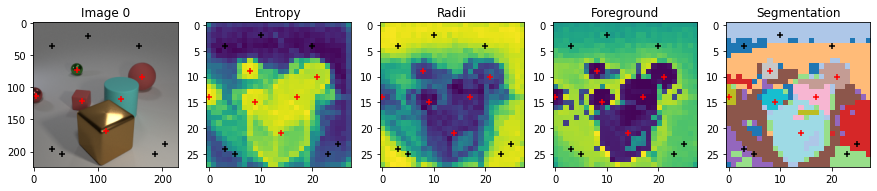

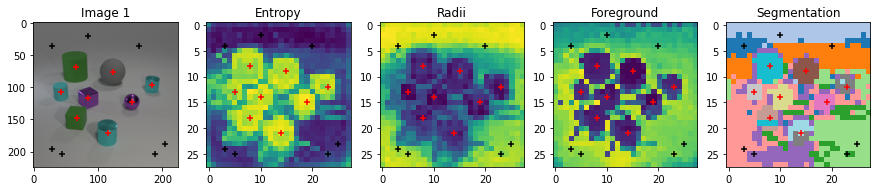

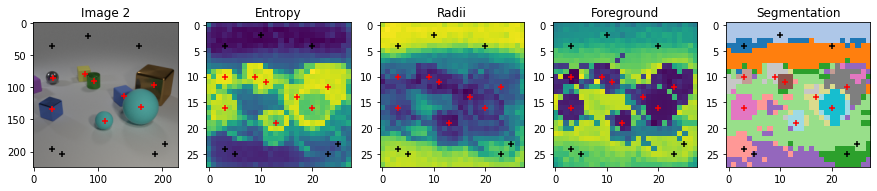

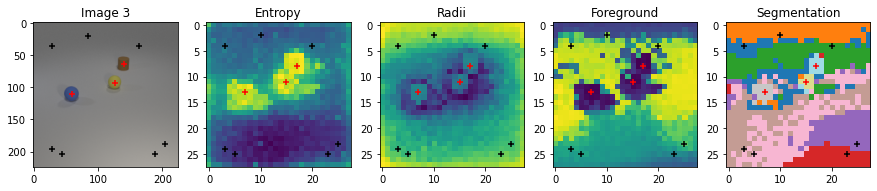

In [10]:
def scale_coords(
    coords_hw: torch.Tensor, from_hw: (int, int), to_hw: (int, int), round=True
):
    scale_factor = torch.tensor([to_hw[0] / from_hw[0], to_hw[1] / from_hw[1]])
    coords_hw = scale_factor * (coords_hw + 0.5) - 0.5
    if round:
        coords_hw = coords_hw.round().int()
    return coords_hw


# Object locations in patch coords
obj_coords_scaled = scale_coords(
    torch.where(visibility[:, :, None], obj_coords, torch.zeros([])),
    imgs_pt.shape[-2:],
    (H, W),
)

# Background locations in patch coords and image coords
bg_coords_scaled = np.array(
    [
        (4, 3),
        (2, 10),
        (4, 20),
        (25, 23),
        (23, 25),
        (24, 3),
        (25, 5),
    ]
)
bg_coords_scaled_flat = np.ravel_multi_index(bg_coords_scaled.T, (H, W))
bg_coords = scale_coords(bg_coords_scaled, (H, W), imgs_pt.shape[-2:])

for b in range(4):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3), facecolor="white")

    ax = axs[0]
    ax.imshow(imgs_np[b])
    ax.scatter(
        obj_coords[b, visibility[b], 1],
        obj_coords[b, visibility[b], 0],
        color="red",
        marker="+",
    )
    ax.scatter(bg_coords[:, 1], bg_coords[:, 0], color="black", marker="+")
    ax.set_title(f"Image {b}")

    ax = axs[1]
    ax.imshow(ent[b].cpu(), interpolation="none")
    ax.scatter(
        obj_coords_scaled[b, visibility[b], 1],
        obj_coords_scaled[b, visibility[b], 0],
        color="red",
        marker="+",
    )
    ax.scatter(
        bg_coords_scaled[:, 1], bg_coords_scaled[:, 0], color="black", marker="+"
    )
    ax.set_title(f"Entropy")

    ax = axs[2]
    ax.imshow(sigmas[b].sqrt().cpu(), interpolation="none")
    ax.scatter(
        obj_coords_scaled[b, visibility[b], 1],
        obj_coords_scaled[b, visibility[b], 0],
        color="red",
        marker="+",
    )
    ax.scatter(
        bg_coords_scaled[:, 1], bg_coords_scaled[:, 0], color="black", marker="+"
    )
    ax.set_title(f"Radii")

    ax = axs[3]
    ax.imshow(fg_percents[b].cpu(), interpolation="none")
    ax.scatter(
        obj_coords_scaled[b, visibility[b], 1],
        obj_coords_scaled[b, visibility[b], 0],
        color="red",
        marker="+",
    )
    ax.scatter(
        bg_coords_scaled[:, 1], bg_coords_scaled[:, 0], color="black", marker="+"
    )
    ax.set_title(f"Foreground")

    ax = axs[4]
    cos_slots = cos[b].reshape(H * W, H, W)
    cos_slots = cos_slots[
        np.concatenate(
            [
                bg_coords_scaled_flat,
                np.ravel_multi_index(
                    obj_coords_scaled[b, visibility[b]].numpy().T, (H, W)
                ),
            ]
        )
    ]
    segm = cos_slots.argmax(dim=0)
    ax.imshow(segm.cpu().numpy(), cmap="tab20", interpolation="none")
    ax.scatter(
        obj_coords_scaled[b, visibility[b], 1],
        obj_coords_scaled[b, visibility[b], 0],
        color="red",
        marker="+",
    )
    ax.scatter(
        bg_coords_scaled[:, 1], bg_coords_scaled[:, 0], color="black", marker="+"
    )
    ax.set_title(f"Segmentation")

    display(fig)
    plt.close(fig)

### Batch statistics

Collect statistics from the batch: can we distinguish objects vs non-objects?

In [11]:
ent_all = reduce(ent, "B H W -> B", reduction="mean")
ent_bg = []
ent_obj = []

rad_all = reduce(sigmas.sqrt(), "B H W -> B", reduction="mean")
rad_bg = []
rad_obj = []

perc_all = reduce(fg_percents, "B H W -> B", reduction="mean")
perc_bg = []
perc_obj = []

ent_flat = rearrange(ent, "B H W -> B (H W)")
radii_flat = rearrange(sigmas.sqrt(), "B H W -> B (H W)")
fg_percents_flat = rearrange(fg_percents, "B H W -> B (H W)")

for b in range(f_patches.shape[0]):
    oc_flat = np.ravel_multi_index(
        obj_coords_scaled[b, visibility[b]].numpy().T, (H, W)
    )
    ent_obj.append(ent_flat[b, oc_flat])
    ent_bg.append(ent_flat[b, bg_coords_scaled_flat])
    rad_obj.append(radii_flat[b, oc_flat])
    rad_bg.append(radii_flat[b, bg_coords_scaled_flat])
    perc_obj.append(fg_percents_flat[b, oc_flat])
    perc_bg.append(fg_percents_flat[b, bg_coords_scaled_flat])

ent_bg = torch.cat(ent_bg, dim=0)
ent_obj = torch.cat(ent_obj, dim=0)
rad_bg = torch.cat(rad_bg, dim=0)
rad_obj = torch.cat(rad_obj, dim=0)
perc_bg = torch.cat(perc_bg, dim=0)
perc_obj = torch.cat(perc_obj, dim=0)

print("ent_bg  ", tuple(ent_bg.shape))
print("ent_obj ", tuple(ent_obj.shape))
print("rad_bg  ", tuple(rad_bg.shape))
print("rad_obj ", tuple(rad_obj.shape))
print("perc_bg ", tuple(perc_bg.shape))
print("perc_obj", tuple(perc_obj.shape))

ent_bg   (896,)
ent_obj  (807,)
rad_bg   (896,)
rad_obj  (807,)
perc_bg  (896,)
perc_obj (807,)


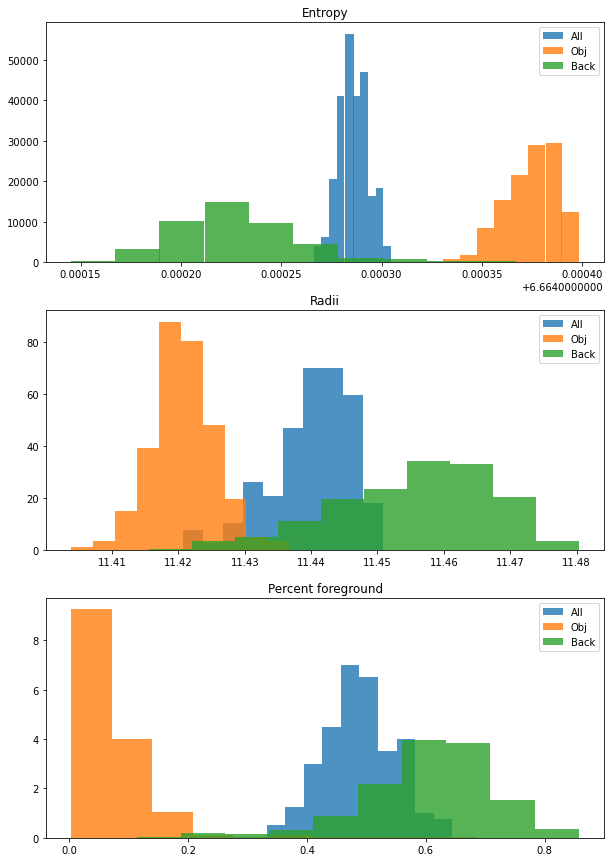

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15), facecolor="white")

ax = axs[0]
ax.hist(ent_all.cpu().numpy(), label="All", density=True, stacked=True, alpha=0.8)
ax.hist(ent_obj.cpu().numpy(), label="Obj", density=True, stacked=True, alpha=0.8)
ax.hist(ent_bg.cpu().numpy(), label="Back", density=True, stacked=True, alpha=0.8)
ax.set_title("Entropy")

ax = axs[1]
ax.hist(rad_all.cpu().numpy(), label="All", density=True, stacked=True, alpha=0.8)
ax.hist(rad_obj.cpu().numpy(), label="Obj", density=True, stacked=True, alpha=0.8)
ax.hist(rad_bg.cpu().numpy(), label="Back", density=True, stacked=True, alpha=0.8)
ax.set_title("Radii")

ax = axs[2]
ax.hist(perc_all.cpu().numpy(), label="All", density=True, stacked=True, alpha=0.8)
ax.hist(perc_obj.cpu().numpy(), label="Obj", density=True, stacked=True, alpha=0.8)
ax.hist(perc_bg.cpu().numpy(), label="Back", density=True, stacked=True, alpha=0.8)
ax.set_title("Percent foreground")

for ax in axs:
    ax.legend()

TODO:

use ground-truth instance masks and see if the attention of the central pixel of an object is reasonably good at segmenting out the instance

Most importantly, check that duplicated instances in the same image are assigned to different clusters/instances in the segmentation.

## What if we don't know the object coords?

In [13]:
def mu_sigma_batched_slots(attn):
    B, S, h, w = attn.shape
    # [h w 2]
    grid = torch.meshgrid(
        torch.arange(h, device=attn.device),
        torch.arange(w, device=attn.device),
        indexing="ij",
    )
    grid = torch.stack(grid, dim=-1)

    # [B, S, h, w, _] * [_, _, h, w, 2] -> [B, S, 2]
    mus = reduce(
        attn[:, :, :, :, None] * grid[None, None, :, :, :],
        "B S h w two -> B S two",
        reduction="sum",
    )

    # [B, S, h, w] * || [_, _, h, w, 2] - [B, S, _, _, 2] ||^2 -> [B S]
    sigmas = reduce(
        attn[:, :, :, :]
        * ((grid[None, None, :, :, :] - mus[:, :, None, None, :]).pow(2).sum(dim=-1)),
        "B S h w -> B S",
        reduction="sum",
    )
    return mus, sigmas


def entropy_batched_slots(attn):
    return reduce(-attn * attn.log(), "B S h w -> B S", reduction="sum")


def otsu_threshold_batched_slots(attn):
    device = attn.device
    out = [otsu_threshold_slots(a) for a in attn.cpu()]
    thresholds = torch.stack([t for t, _ in out], dim=0).to(device)
    fg_percents = torch.stack([p for _, p in out], dim=0).to(device)
    # [B S], [B S]
    return thresholds, fg_percents


def otsu_threshold_slots(attn):
    S, h, w = attn.shape
    attn_np = attn.cpu().numpy()
    thresholds = np.empty(S)
    for s in range(S):
        thresholds[s] = threshold_otsu(attn_np[s, :, :])
    thresholds = torch.from_numpy(thresholds).to(attn.device)
    fg_percents = attn > thresholds[:, None, None]
    fg_percents = torch.count_nonzero(fg_percents, dim=(-2, -1)) / (h * w)
    return thresholds, fg_percents

Queries ~ normal:
- needs competitive attention updates with high number of iterations
- works well with `direction=competitive` and `num_iters=9` but sometimes it captures
  groups of objects instead of instances

Queries ~ patches:
- no big difference between not doing any iteration and iterating regular/competitive attention
- competitive updates give slightly cleaner segmentations

direction='competitive' queries='normal' num_iters=9


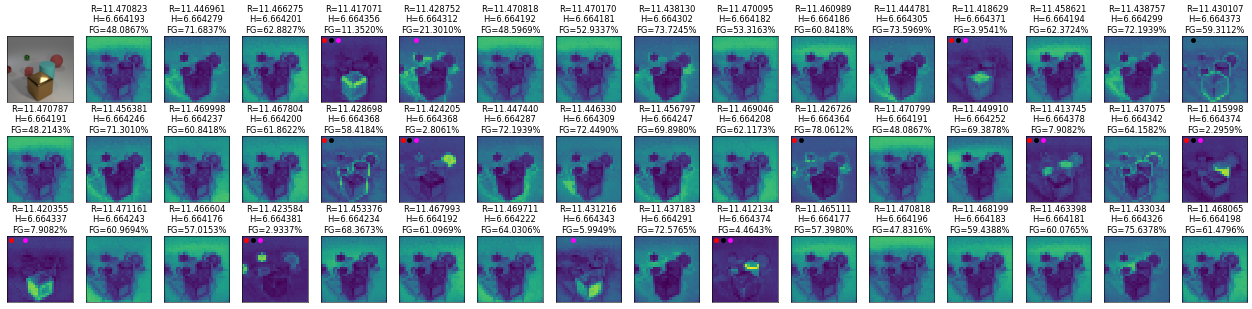

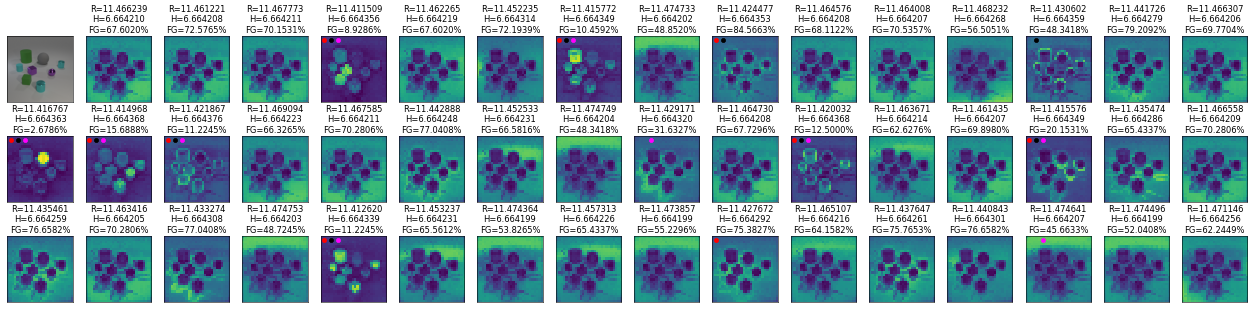

direction='_' queries='patches' num_iters=0


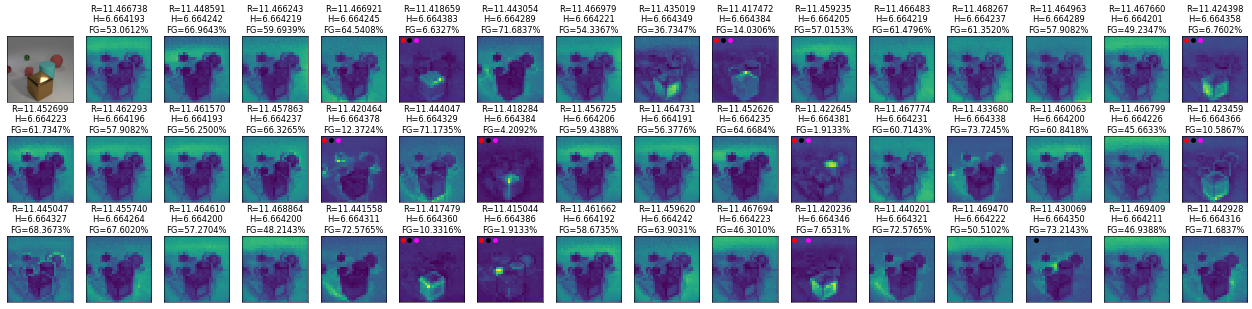

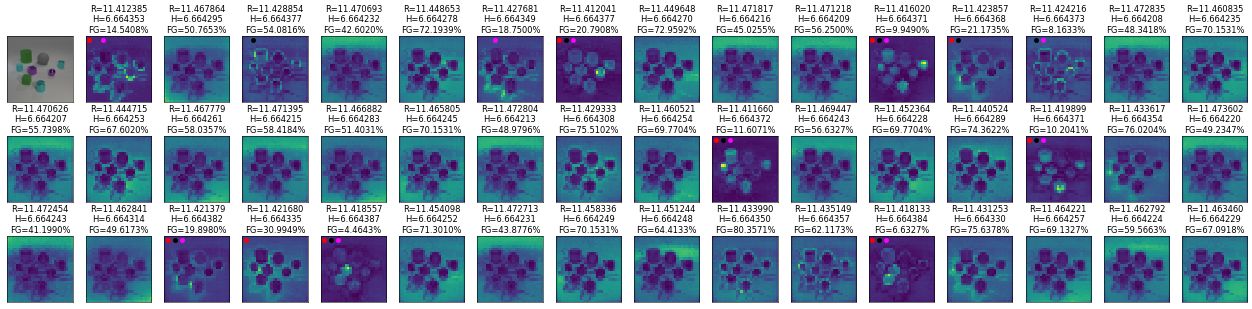

direction='regular' queries='patches' num_iters=1


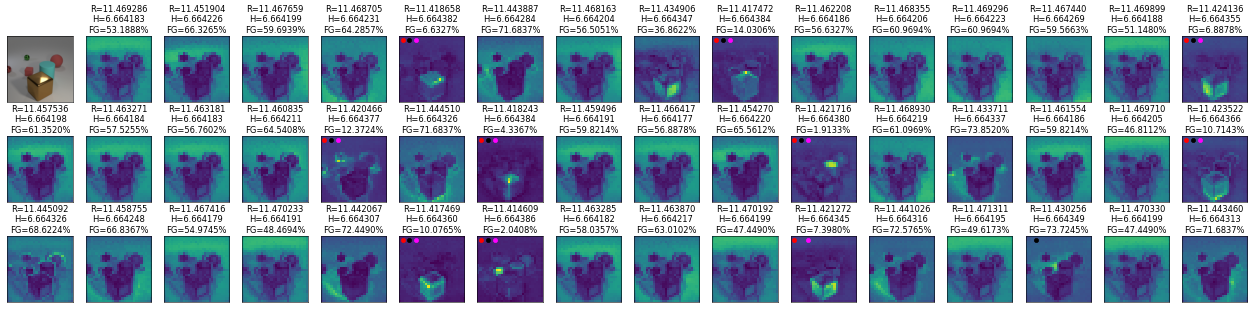

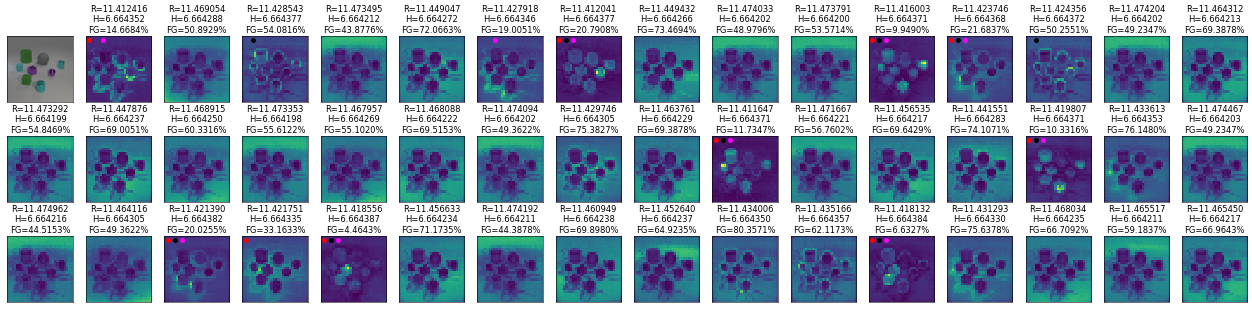

direction='competitive' queries='patches' num_iters=1


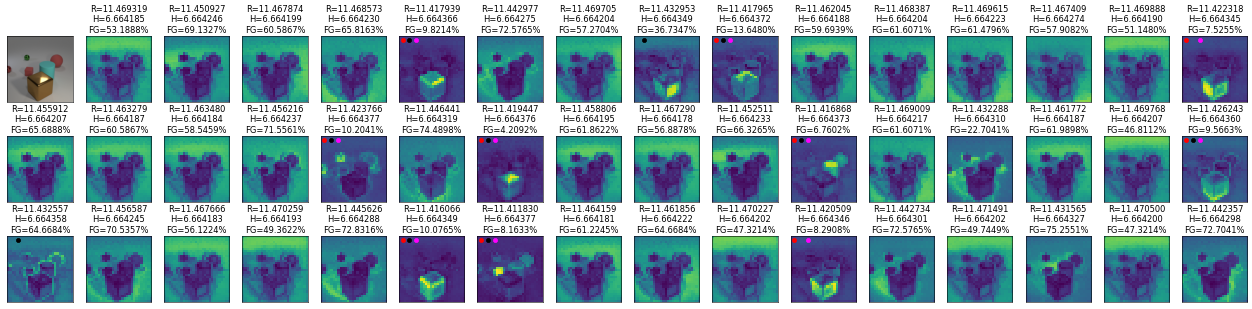

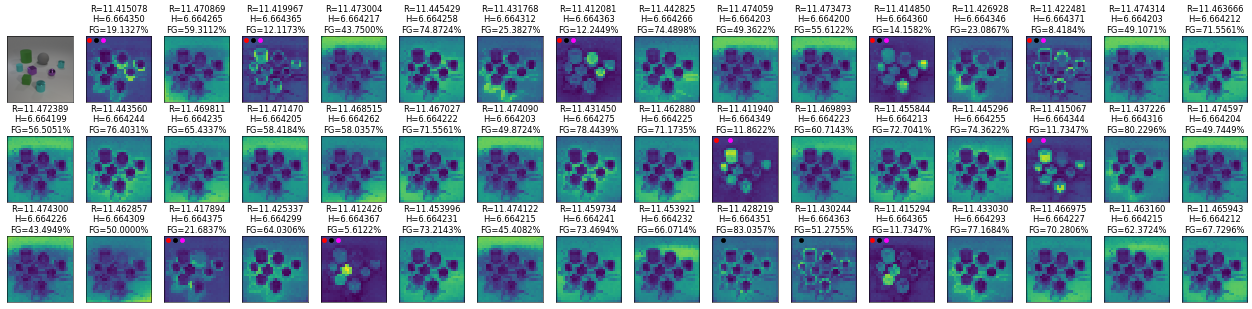

direction='regular' queries='patches' num_iters=9


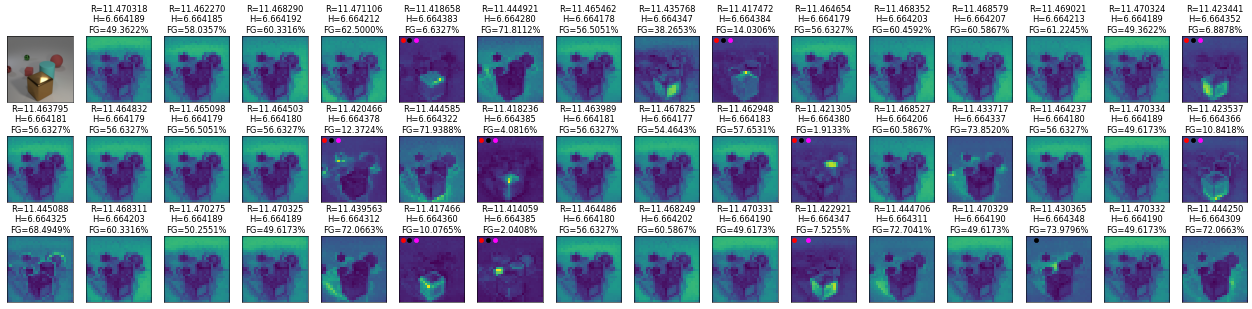

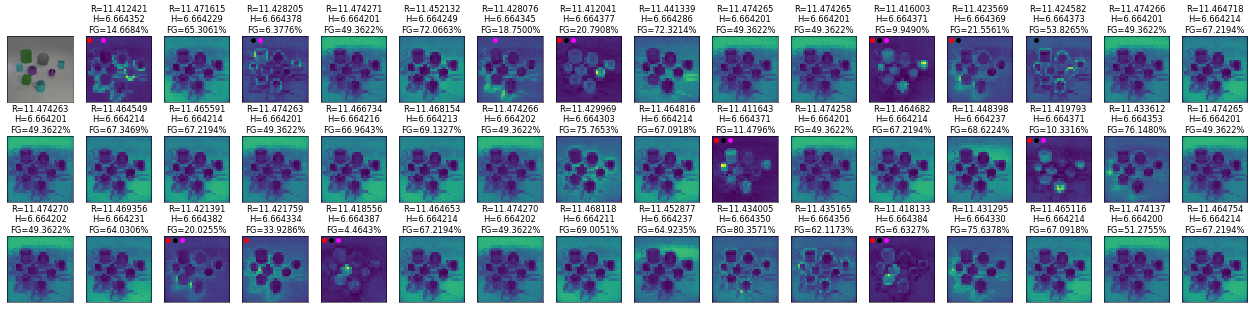

direction='competitive' queries='patches' num_iters=9


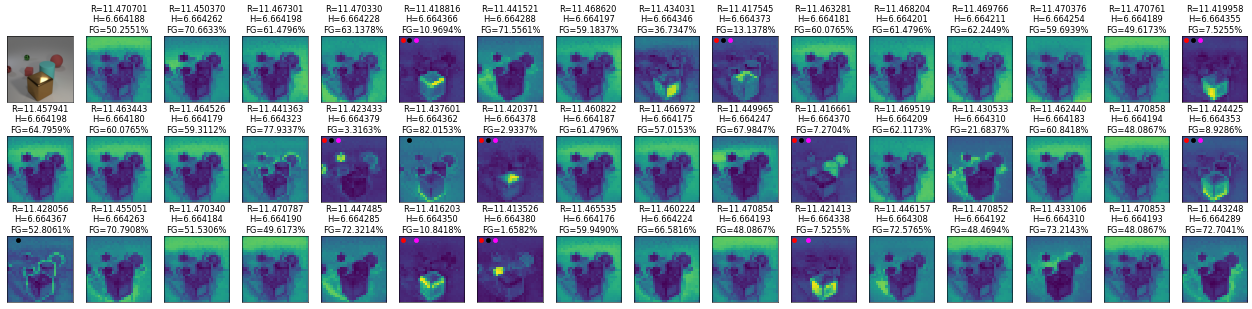

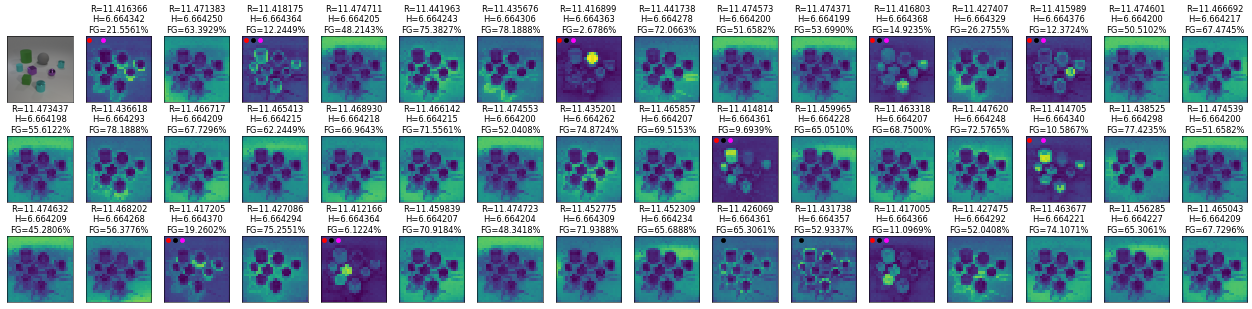

In [23]:
S = 47
temperature = 0.5

B, H, W, C = f_patches.shape
k = F.layer_norm(rearrange(f_patches, "B H W C -> B (H W) C"), (C,))

for direction, queries, num_iters in [
    # fmt: off
    # ("_",           "normal",  0), # doesn't work
    # ("regular",     "normal",  1), # doesn't work
    # ("competitive", "normal",  1), # doesn't work
    # ("regular",     "normal",  9), # doesn't work
    ("competitive", "normal",  9),  # good
    # ---------------------------
    ("_",           "patches", 0),
    ("regular",     "patches", 1),
    ("competitive", "patches", 1),
    ("regular",     "patches", 9),
    ("competitive", "patches", 9),
    # fmt: on
]:
    print(f"{direction=} {queries=} {num_iters=}")

    if queries == "normal":
        torch.manual_seed(0)
        obj_queries = torch.randn(B, S, C, device=k.device)
    elif queries == "patches":
        torch.manual_seed(0)
        obj_queries = torch.randint(0, H * W, (B, S), device=k.device)
        obj_queries = obj_queries[:, :, None].expand(B, S, C)
        obj_queries = torch.gather(k, dim=1, index=obj_queries)
    else:
        raise NotImplementedError(queries)

    for _ in range(num_iters):
        obj_queries = F.layer_norm(obj_queries, (C,))
        attn = torch.einsum("bqc, bkc -> bqk", obj_queries, k).div_(np.sqrt(C))
        if direction == "regular":
            attn = attn.softmax(dim=-1)
        elif direction == "competitive":
            attn = attn.softmax(dim=-2)
            attn = attn / attn.add(1e-6).sum(dim=-1, keepdim=True)
        else:
            raise NotImplementedError(direction)
        obj_queries = torch.einsum("bqk, bkc -> bqc", attn, k)

    cos = torch.einsum(
        "bsc, bhwc -> bshw",
        obj_queries / obj_queries.norm(dim=-1, keepdim=True),
        f_patches / f_patches.norm(dim=-1, keepdim=True),
    )
    attn = rearrange(cos, "B S h w -> B S (h w)")
    attn = attn.div(temperature * np.sqrt(C)).softmax(-1)
    attn = rearrange(attn, "B S (h w) -> B S h w", h=H)

    radii = mu_sigma_batched_slots(attn)[1].sqrt()
    _, radii_topk = radii.topk(10, dim=-1, largest=False)
    ent = entropy_batched_slots(attn)
    _, ent_topk = ent.topk(10, dim=-1, largest=True)
    _, fg_percents = otsu_threshold_batched_slots(attn)
    _, fg_percents_topk = fg_percents.topk(10, dim=-1, largest=False)

    for b in range(2):
        fig, axs = plt.subplots(
            math.ceil((S + 1) / 16),
            16,
            figsize=2 * np.array([16, 1.25 * math.ceil((S + 1) / 16)]),
            facecolor="white",
            squeeze=False,
            dpi=50,
        )
        axs[0, 0].imshow(imgs_np[b])

        for s in range(S):
            ax = axs.flat[s + 1]
            ax.imshow(attn[b, s].cpu().numpy(), interpolation="none", vmax=attn[b].max().item())
            ax.set_title(
                f"R={radii[b,s]:.6f}\nH={ent[b,s]:.6f}\nFG={fg_percents[b,s]:.4%}"
            )
        for topk in radii_topk[b].tolist():
            axs.flat[topk + 1].scatter(1, 1, color="red")
        for topk in ent_topk[b].tolist():
            axs.flat[topk + 1].scatter(4, 1, color="black")
        for topk in fg_percents_topk[b].tolist():
            axs.flat[topk + 1].scatter(7, 1, color="magenta")

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        display(fig)
        plt.close(fig)